# Implementation of Softmax Regression from Scratch

Let's implement Softmax Regression.
We will work with the Fashion-MNIST dataset, setting up a data iterator with batch size 256.


In [59]:
import torch
from IPython import display
from d2l import torch as d2l

In [60]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

## Initializing Model Parameters

As in our linear regression example,
each example here will be represented by a fixed-length vector.

Each example in the raw dataset is a $28 \times 28$ image.
In this section, [**we will flatten each image,
treating them as vectors of length 784.**]

Recall that in softmax regression,
we have as many outputs as there are classes.
(**Because our dataset has 10 classes,
our network will have an output dimension of 10.**)

Our weights will constitute a $784 \times 10$ matrix
and the biases will constitute a $1 \times 10$ row vector.

As with linear regression, we will initialize our weights `W`
with Gaussian noise and our biases to take the initial value 0.


In [61]:
num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

## Defining the Softmax Operation

Sum for column (axis 0) / row (axis 1).

Note that if `X` is a tensor with shape (2, 3)
and we sum over the columns,
the result will be a vector with shape (3,).

When invoking the sum operator, `keepdim=True` results in a two-dimensional tensor with shape (1, 3).


In [62]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdim=True), X.sum(1, keepdim=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

Softmax consists of three steps:
(i) we exponentiate each term (using `exp`);
(ii) we sum over each row (we have one row per example in the batch)
to get the normalization constant for each example;
(iii) we divide each row by its normalization constant,
ensuring that the result sums to 1.

$$\mathrm{softmax}(\mathbf{X})_{ij} = \frac{\exp(\mathbf{X}_{ij})}{\sum_k \exp(\mathbf{X}_{ik})}.$$

Note that the denominator, or normalization constant,
is also sometimes called the *partition function*


In [63]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition  # The broadcasting mechanism is applied here

For any random input,
* **Turn each element into a non-negative number.**
* **Each row sums up to 1**

as is required for a probability.


In [7]:
X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X, X_prob, X_prob.sum(1)

(tensor([[ 0.3866,  1.5005,  0.7820, -2.0807, -0.0191],
         [ 0.5901, -1.5595,  2.4809,  1.3227, -0.2644]]),
 tensor([[0.1592, 0.4849, 0.2364, 0.0135, 0.1061],
         [0.0976, 0.0114, 0.6465, 0.2030, 0.0415]]),
 tensor([1.0000, 1.0000]))

Note that while this looks correct mathematically,
we were a bit sloppy in our implementation
because we failed to take precautions against numerical overflow or underflow
due to large or very small elements of the matrix.

## Defining the Model

Then we can [**implement the softmax regression model.**]
The below code defines how the input is mapped to the output through the network.


In [57]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

## Defining the Loss Function

Next, we need to implement the cross-entropy loss function.
This may be the most common loss function
in all of deep learning because, at the moment,
classification problems far outnumber regression problems.

Below, we [**create sample data `y_hat`
with 2 examples of predicted probabilities over 3 classes and their corresponding labels `y`.**]

With `y` we know that in the first example the first class is the correct prediction and
in the second example the third class is the ground-truth.

[**Using `y` as the indices of the probabilities in `y_hat`,**]
we pick the probability of the first class in the first example
and the probability of the third class in the second example.


In [37]:
y = torch.tensor([0, 2]) # true label
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]]) # predicted probability
y, y_hat, y_hat[[0, 1], y]

(tensor([0, 2]),
 tensor([[0.1000, 0.3000, 0.6000],
         [0.3000, 0.2000, 0.5000]]),
 tensor([0.1000, 0.5000]))

Now we can (**implement the cross-entropy loss function**) efficiently with just one line of code.
$$ l(\mathbf{y}, \hat{\mathbf{y}}) = - \sum_{j=1}^q y_j \log \hat{y}_j. $$


In [46]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])
cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

Let's compare it with the results of Pytorch built-in Cross Entropy: `nn.CrossEntropyLoss`

In [22]:
from torch import nn
loss = nn.CrossEntropyLoss(reduction='none')
loss(y_hat, y)

tensor([1.3533, 0.9398])

Different, but why?

`nn.CrossEntropyLoss` includes the Softmax

In [ ]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])
soft_y_hat= torch.nn.Softmax(dim=-1)(y_hat)
cross_entropy(soft_y_hat, y)

You may be curious about the `reduction` parameter.

In [47]:
loss = nn.CrossEntropyLoss(reduction='none')
loss2 = nn.CrossEntropyLoss(reduction='sum')
loss3 = nn.CrossEntropyLoss(reduction='mean')
loss(y_hat, y), loss2(y_hat, y), loss3(y_hat, y)

(tensor([1.3533, 0.9398]), tensor(2.2931), tensor(1.1466))

## Classification Accuracy

Given the predicted probability distribution `y_hat`,
we typically choose the class with the highest predicted probability
whenever we must output a hard prediction.

When predictions are consistent with the label class `y`, they are correct.
The classification accuracy is the fraction of all predictions that are correct.

Although it can be difficult to optimize accuracy directly (it is not differentiable),
it is often the performance measure that we care most about,
and we will nearly always report it when training classifiers.


First, if `y_hat` is a matrix,
we assume that the second dimension (axis=1) stores prediction scores for each class.

We use `argmax` to obtain the predicted class by the index for the largest entry in each row.
Then we [**compare the predicted class with the ground-truth `y` elementwise.**]

Since the equality operator `==` is sensitive to data types,
we convert `y_hat`'s data type to match that of `y`.

The result is a tensor containing entries of 0 (false) and 1 (true).
Taking the sum yields the number of correct predictions.

In [48]:
def accuracy(y_hat, y):  #@save
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

The first example's prediction class is 2
(the largest element of the row is 0.6 with the index 2),
which is inconsistent with the actual label, 0.

The second example's prediction class is 2
(the largest element of the row is 0.5 with the index of 2),
which is consistent with the actual label, 2.

In [52]:
y_hat, y_hat.argmax(axis=1), y

(tensor([[0.1000, 0.3000, 0.6000],
         [0.3000, 0.2000, 0.5000]]),
 tensor([2, 2]),
 tensor([0, 2]))

Therefore, the classification accuracy rate for these two examples is 0.5.

In [51]:
accuracy(y_hat, y) / len(y)

0.5


[**Similarly, we can evaluate the accuracy for any model `net` on a dataset**]
that is accessed via the data iterator `data_iter`.


In [64]:
def evaluate_accuracy(net, data_iter):  #@save
    """Compute the accuracy for a model on a dataset."""
    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
    metric = Accumulator(2)  # No. of correct predictions, no. of predictions

    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

Here `Accumulator` is a utility class to accumulate sums over multiple variables.
In the above `evaluate_accuracy` function,
we create 2 variables in the `Accumulator` instance for storing both
the number of correct predictions and the number of predictions, respectively.
Both will be accumulated over time as we iterate over the dataset.


In [65]:
class Accumulator:  #@save
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

[**Because we initialized the `net` model with random weights,
the accuracy of this model should be close to random guessing,**]
i.e., 0.1 for 10 classes.


In [66]:
evaluate_accuracy(net, test_iter)

0.1184

## Training
First, we define a function to train for one epoch.
Note that `updater` is a general function to update the model parameters,
which accepts the batch size as an argument.
It can be either a wrapper of the `d2l.sgd` function
or a framework's built-in optimization function.


In [74]:
def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """The training loop defined in Chapter 3."""
    # Set the model to training mode
    if isinstance(net, torch.nn.Module):
        net.train()
    # Sum of training loss, sum of training accuracy, no. of examples
    metric = Accumulator(3)
    for X, y in train_iter:
        # Compute gradients and update parameters
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # Using PyTorch in-built optimizer & loss criterion
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # Using custom built optimizer & loss criterion
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]

Before showing the implementation of the training function,
we define [**a utility class that plot data in animation.**]


In [75]:
class Animator:  #@save
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

The following training function then
trains a model `net` on a training dataset accessed via `train_iter`
for multiple epochs, which is specified by `num_epochs`.
At the end of each epoch,
the model is evaluated on a testing dataset accessed via `test_iter`.
We will leverage the `Animator` class to visualize
the training progress.


In [76]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """Train a model (defined in Chapter 3)."""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

As an implementation from scratch,
we [**use the minibatch stochastic gradient descent**]
to optimize the loss function of the model with a learning rate 0.1.


In [79]:
lr = 0.1

def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

Now we [**train the model with 10 epochs.**]
Note that both the number of epochs (`num_epochs`),
and learning rate (`lr`) are adjustable hyperparameters.
By changing their values, we may be able
to increase the classification accuracy of the model.


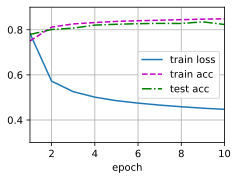

In [78]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

## Prediction

Now that training is complete,
our model is ready to [**classify some images.**]
Given a series of images,
we will compare their actual labels
(first line of text output)
and the predictions from the model
(second line of text output).


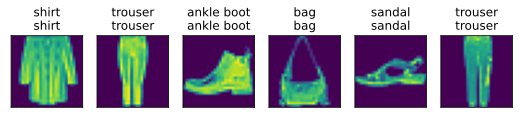

In [86]:
def predict_ch3(net, test_iter, n=6):  #@save
    """Predict labels (defined in Chapter 3)."""
    i = 0
    for X, y in test_iter:
        i += 1
        if i == 3:
            break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)